# Scott Wilcockson scRNA Data Analysis for Drosophila (updated with Filter read counts = 2 and number of cells a gene observed to 4)
This is a jupyter notebook to process Scott Wilcockson single-cell RNA-seq data on __Drosophila__ germline stem cells and cytoblasts. A objective of the project is to do the heterogeneity analysis of the two types of cells. Rows A, B, C, D contain germline stem cells and Rows E, F, G and H contains cytoblasts.

In [2]:
import subprocess, os, csv, signal, pysam, collections, optparse, sys, tempfile, re, optparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pylab
import plotly
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
import readline
import rpy2.robjects

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [4]:
%load_ext rpy2.ipython

In [6]:
%%R
library(scde)
library(DESeq2)
library(ggplot2)
#library(made4)
library(irlba)
library(scater)
library(scran)
library(ComplexHeatmap)
library(genefilter)
library(ccRemover)
library(Rtsne)
library(plotly)
library(MASS)
library(M3Drop)
library(GGally)
library(monocle)
library(reshape)

Reading the gene names of Drosophelia Genes

In [7]:
%%R
GeneName <- read.table("/home/baker/Rna-seq_Data-Analysis/Scott_Wilcockson_Single_cell_RNA/Drosophelia_genename.csv", row.names=1)

Reading the count files. I had to modify the count files as it had the no_features stats generated from the htseq tool. I removed those information as they are not needed for this analysis. Then I print the column name of the mapping summary.

In [8]:
%%R
cd <- read.csv('/home/baker/Rna-seq_Data-Analysis/Scott_Wilcockson_Single_cell_RNA/AllHtseqCounts_Scott_Modified.csv', row.names=1)
cdAnnot<-cd
rownames(cdAnnot) <- GeneName$V2
a <- gsub('^C','', colnames(cdAnnot))
a <- gsub('_[A-z]*[0-9]*','', a)
colnames(cdAnnot) <- a
#write.csv(cdAnnotAll,'/home/baker/Rna-seq_Data-Analysis/Amy_Adlard_scRNA/cdAnnotAll.csv')

In [9]:
%%R
MappingSummary <- read.csv('/home/baker/Rna-seq_Data-Analysis/Scott_Wilcockson_Single_cell_RNA/MappingSummaryAll.csv', row.names=1)

mRNAno <- colSums(cdAnnot)
MappingSummary$mRNAno <- mRNAno

cdAnnotBinary <- cdAnnot
cdAnnotBinary[cdAnnotBinary > 0] <- 1
No_of_Genes_Detected <- colSums(cdAnnotBinary)

MappingSummary$No_Genes_Detected <- No_of_Genes_Detected

colnames(MappingSummary)


[1] "Number_of_input_reads"        "Uniquely_mapped_reads_number"
[3] "Percent_Uniquely_Mapped"      "Percent_of_unmapped"         
[5] "CellType"                     "mRNAno"                      
[7] "No_Genes_Detected"           


Percent of cells with percent of unmapped reads lower than 20%

In [10]:
%%R
(sum(MappingSummary$Percent_of_unmapped < 20)/dim(cdAnnot)[2])*100

[1] 87.5


We now want to see how is the distribution of the mapping percent across and total reads accross samples

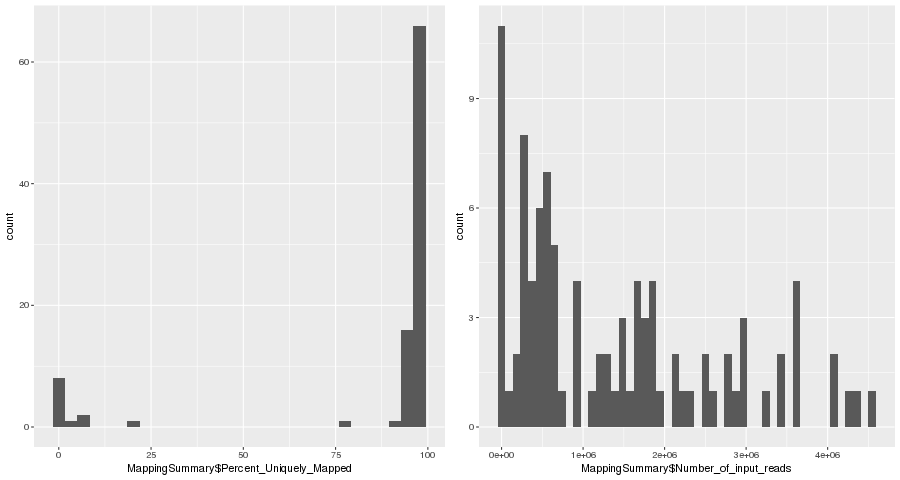

In [11]:
%%R -w 900
p<-qplot(MappingSummary$Percent_Uniquely_Mapped, geom="histogram", bins=30)
p1<-qplot(MappingSummary$Number_of_input_reads, geom="histogram", bins=50)
multiplot(p,p1, cols=2)

We can see that about 12 cells have reads close to 0 and also similar cells have very low percent uniquely mapped reads. This prompts us to look in to the mapping summary. We found that the cell in row __H__ failed and there is no viable cell in that row. So we will drop those cells.

As the cells are __FACS__ sorted, many of the QC we would do for C1 Fluidigm is not needed here.

In [12]:
%%R
cdAnnot <- cdAnnot [,-which(gsub('[0-9_S]','', colnames(cdAnnot)) == 'H')]
colnames(cdAnnot)

 [1] "A01" "A02" "A03" "A04" "A05" "A06" "A07" "A08" "A09" "A10" "A11" "A12"
[13] "B01" "B02" "B03" "B04" "B05" "B06" "B07" "B08" "B09" "B10" "B11" "B12"
[25] "C01" "C02" "C03" "C04" "C05" "C06" "C07" "C08" "C09" "C10" "C11" "C12"
[37] "D01" "D02" "D03" "D04" "D05" "D06" "D07" "D08" "D09" "D10" "D11" "D12"
[49] "E01" "E02" "E03" "E04" "E05" "E06" "E07" "E08" "E09" "E10" "E11" "E12"
[61] "F01" "F02" "F03" "F04" "F05" "F06" "F07" "F08" "F09" "F10" "F11" "F12"
[73] "G01" "G02" "G03" "G04" "G05" "G06" "G07" "G08" "G09" "G10" "G11" "G12"


In [13]:
%%R
MappingSummary <- MappingSummary[-which(gsub('[0-9_S]','', rownames(MappingSummary)) == 'H') , ]
rownames(MappingSummary)

 [1] "A01" "A02" "A03" "A04" "A05" "A06" "A07" "A08" "A09" "A10" "A11" "A12"
[13] "B01" "B02" "B03" "B04" "B05" "B06" "B07" "B08" "B09" "B10" "B11" "B12"
[25] "C01" "C02" "C03" "C04" "C05" "C06" "C07" "C08" "C09" "C10" "C11" "C12"
[37] "D01" "D02" "D03" "D04" "D05" "D06" "D07" "D08" "D09" "D10" "D11" "D12"
[49] "E01" "E02" "E03" "E04" "E05" "E06" "E07" "E08" "E09" "E10" "E11" "E12"
[61] "F01" "F02" "F03" "F04" "F05" "F06" "F07" "F08" "F09" "F10" "F11" "F12"
[73] "G01" "G02" "G03" "G04" "G05" "G06" "G07" "G08" "G09" "G10" "G11" "G12"


## QC analysis
At the start of the QC analysis we do different plots to visualize the summary statistics for the mapped and unmapped reads


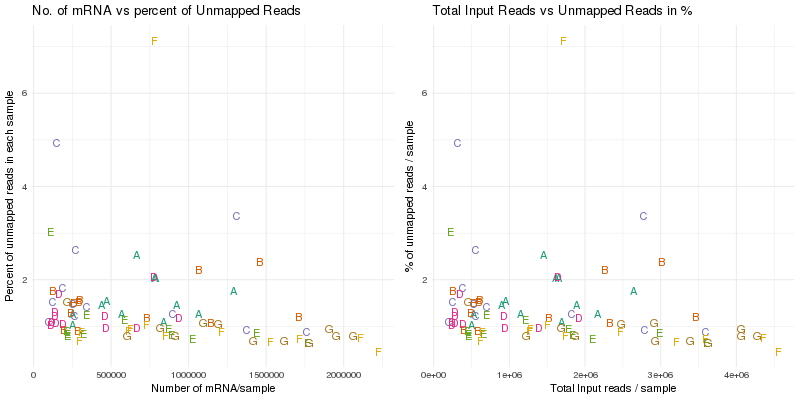

In [14]:
%%R -w 800 -h 400
df<-data.frame(X=MappingSummary$mRNAno,Y=MappingSummary$Percent_of_unmapped, CellStatus=as.factor(gsub('[0-9_S]','', colnames(cdAnnot))))
p1 <- ggplot(df, aes_string(x="X",y ="Y",color="CellStatus")) +
      ggtitle("No. of mRNA vs percent of Unmapped Reads") +
      geom_text(aes(label = CellStatus)) +
      labs(x = "Number of mRNA/sample", y = "Percent of unmapped reads in each sample") +
      scale_color_brewer(palette = "Dark2") +
      theme_bw()+
      theme(legend.position = "none",
            legend.background = element_rect(fill = "white"),
            strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())


df<-data.frame(X=MappingSummary$Number_of_input_reads,Y=MappingSummary$Percent_of_unmapped, CellStatus=as.factor(gsub('[0-9_S]','', colnames(cdAnnot))))
p <- ggplot(df, aes_string(x="X",y ="Y",color="CellStatus")) + 
     ggtitle("Total Input Reads vs Unmapped Reads in %") +
     geom_text(aes(label = CellStatus)) +
     labs(x = "Total Input reads / sample", y = "% of unmapped reads / sample") +
     scale_color_brewer(palette = "Dark2") +
     theme_bw()+
     theme(legend.position = "none",
           legend.background = element_rect(fill = "white"),
           strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())

multiplot(p1, p, cols=2)

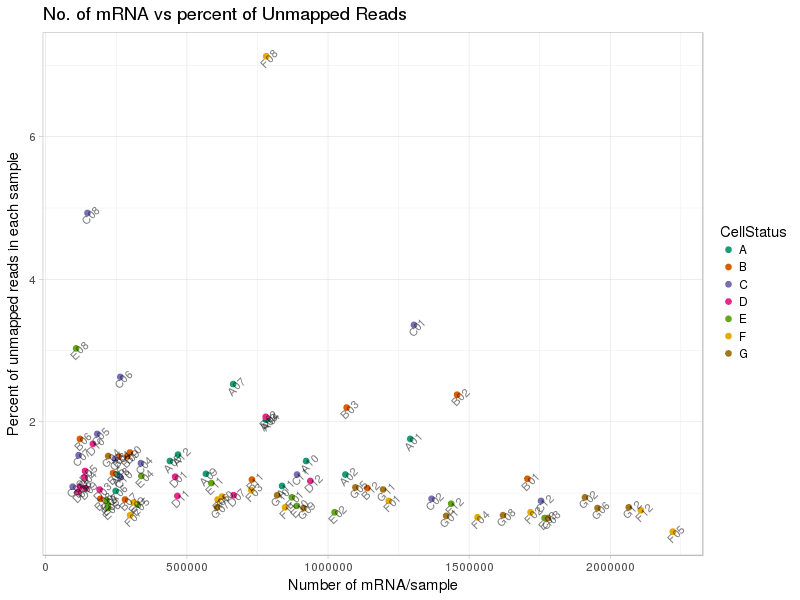

In [15]:
%%R -w 800 -h 600
df<-data.frame(X=MappingSummary$mRNAno,Y=MappingSummary$Percent_of_unmapped, CellStatus=as.factor(gsub('[0-9_S]','', colnames(cdAnnot))))
p <- ggplot(df, aes_string(x="X",y ="Y",color="CellStatus")) +     
     geom_point(size=2.5) +
     ggtitle("No. of mRNA vs percent of Unmapped Reads") +
     labs(x = "Number of mRNA/sample", y = "Percent of unmapped reads in each sample") +
     scale_color_brewer(palette = "Dark2") +
     theme_light(base_size=15) +
     geom_text(data=df,aes(label=colnames(cdAnnot)),
               alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
p

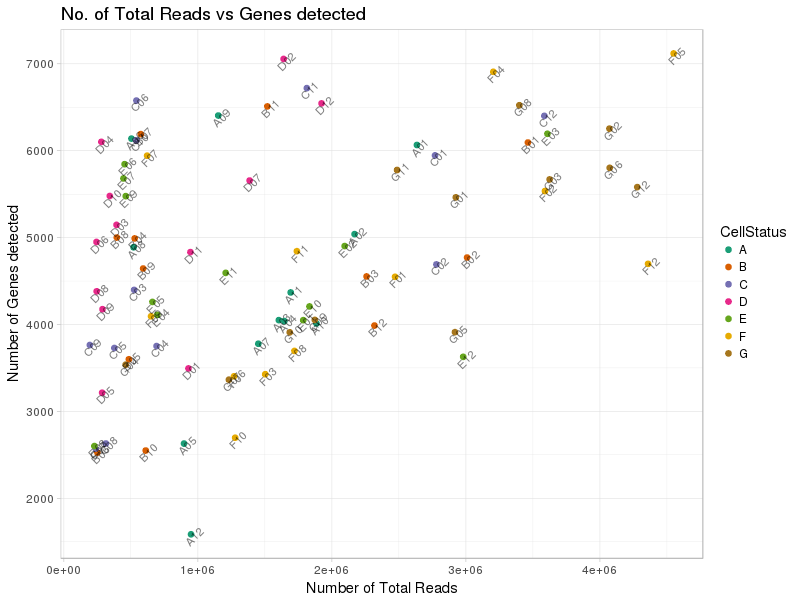

In [16]:
%%R -w 800 -h 600
df<-data.frame(X=MappingSummary$Number_of_input_reads,Y=MappingSummary$No_Genes_Detected, CellStatus=as.factor(gsub('[0-9_S]','', colnames(cdAnnot))))
p <- ggplot(df, aes_string(x="X",y ="Y",color="CellStatus")) +     
     geom_point(size=2.5) +
     ggtitle("No. of Total Reads vs Genes detected") +
     labs(x = "Number of Total Reads", y = "Number of Genes detected") +
     scale_color_brewer(palette = "Dark2") +
     theme_light(base_size=15) +
     geom_text(data=df,aes(label=colnames(cdAnnot)),
               alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
p


We will now do a density plot to choose the cutoff value for our QC

## Coefficient of Variation

In [17]:
%%R
CV <- function(mean, sd){
      (sd/mean)^2
}

In [18]:
%%R
cellCV <- CV(colMeans(cdAnnot),apply(cdAnnot, 2, sd))
mRNACV <- CV(rowMeans(cdAnnot),apply(cdAnnot, 1, sd))

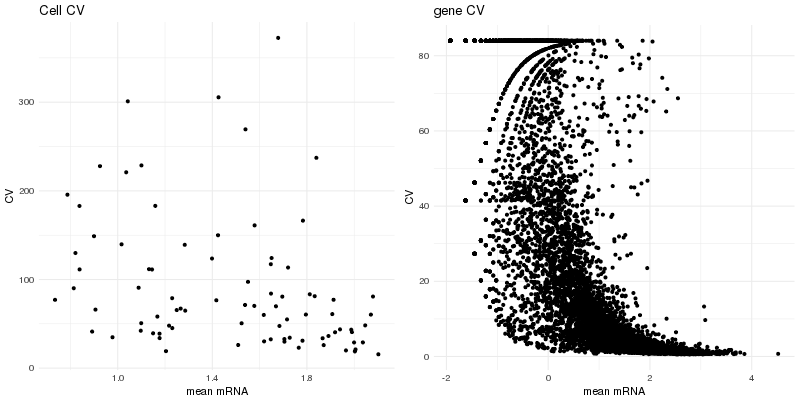

In [19]:
%%R -w 800 -h 400
df <- data.frame(X=log10(colMeans(cdAnnot)),Y=cellCV)
cellP <- ggplot(df, aes_string(x="X",y ="Y")) + 
      ggtitle("Cell CV") +
      geom_point(size=1.25) +
      labs(x = "mean mRNA", y = "CV") +
      theme_bw()+
      theme(legend.position = "none",
            legend.background = element_rect(fill = "white"),
            strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())

df <- data.frame(X=log10(rowMeans(cdAnnot)),Y=mRNACV)
mRNAP <- ggplot(df, aes_string(x="X",y ="Y")) + 
      ggtitle("gene CV") +
      geom_point(size=1.25) +
      labs(x = "mean mRNA", y = "CV") +
      theme_bw()+
      theme(legend.position = "none",
            legend.background = element_rect(fill = "white"),
            strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())

multiplot(cellP, mRNAP, cols=2)

## Applying scater on the whole dataset (without filtering the bad cells)

In [20]:
%%R
DataInfo <- data.frame(Cell=colnames(cdAnnot), CellType=MappingSummary$CellType)
rownames(DataInfo) <- colnames(cdAnnot)
pd <- new("AnnotatedDataFrame", data = DataInfo)
rownames(pd) <- pd$Cell
cdSceset <- newSCESet(countData = cdAnnot, phenoData = pd)
cdSceset <- calculateQCMetrics(cdSceset)

In [21]:
%%R
plotQC(cdSceset, type = "highest-expression")


Error in `$<-.data.frame`(`*tmp*`, "Feature", value = integer(0)) : 
  replacement has 0 rows, data has 4200


/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

Error in `$<-.data.frame`(`*tmp*`, "Feature", value = integer(0)) : 
  replacement has 0 rows, data has 4200


/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

In addition: 

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

Warning message:


/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

Removed 6218 rows containing missing values (geom_point). 




The above figure shows how many genes are expressed based on the percent of totall cells before filtering.

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

`geom_smooth()` using method = 'gam'




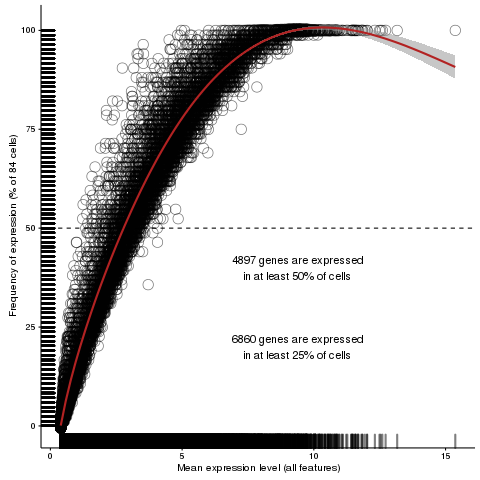

In [22]:
%%R
plotQC(cdSceset, type = "exprs-freq-vs-mean")

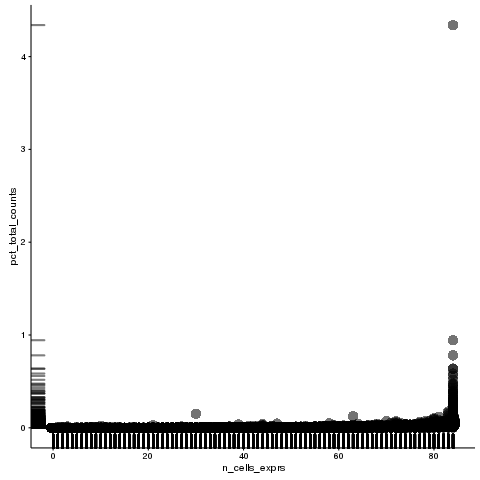

In [23]:
%%R
plotFeatureData(cdSceset, aes(x = n_cells_exprs, y = pct_total_counts))

The above figure shows what percent of genes are expressed across how many cells. Each of the dots represent a gene. The Y-axis shows the percent of total counts that each of the gene took. Here we see a fair number of genes are expressed across all the cells and few of them are taking a large portion of all the reads.

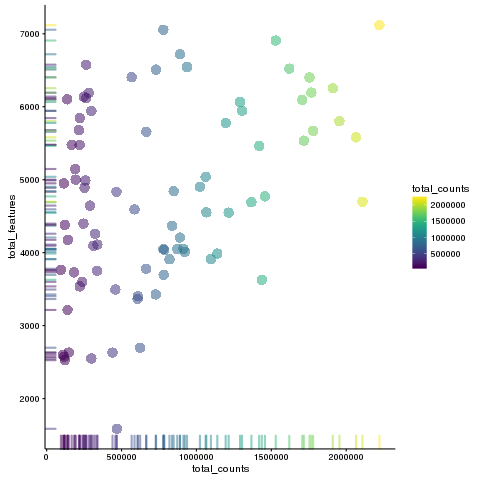

In [24]:
%%R
plotPhenoData(cdSceset, aes(x = total_counts, y = total_features,
                                  colour = total_counts))

In the above figure it shows, how many total features(feature represents gene here) are found across total_counts. For the highest count we see that number of total features are not the maximum. This indicates that there are few genes which takes up majority of the reads.

## Cell Filtering
__This is a major step to remove the bad cells__

We will now filter the cells. We will still apply `scde::clean.counts` to filter out the bed cells. However, after filtering we will look at the previous figures so confirm whether they agree with our threshold and with our identification of bad cells

In [25]:
%%R
cdFiltered <- clean.counts(cdAnnot, min.lib.size = 1800, min.reads = 2, min.detected = 4)
print(paste("Before Filtering (genes): ", dim(cdAnnot)[1]))
print(paste("Before Filtering (Cells): ", dim(cdAnnot)[2]))
print(paste("After Filtering (genes): ", dim(cdFiltered)[1]))
print(paste("After Filtering (cells): ", dim(cdFiltered)[2]))

[1] "Before Filtering (genes):  17559"
[1] "Before Filtering (Cells):  84"
[1] "After Filtering (genes):  8613"
[1] "After Filtering (cells):  83"


In [29]:
%%R
write.csv(cdFiltered, 'cdFiltered_Read_2_cell_4.csv',row.names=TRUE)

In [26]:
%%R
print(colnames(cdAnnot))
print(colnames(cdFiltered))

 [1] "A01" "A02" "A03" "A04" "A05" "A06" "A07" "A08" "A09" "A10" "A11" "A12"
[13] "B01" "B02" "B03" "B04" "B05" "B06" "B07" "B08" "B09" "B10" "B11" "B12"
[25] "C01" "C02" "C03" "C04" "C05" "C06" "C07" "C08" "C09" "C10" "C11" "C12"
[37] "D01" "D02" "D03" "D04" "D05" "D06" "D07" "D08" "D09" "D10" "D11" "D12"
[49] "E01" "E02" "E03" "E04" "E05" "E06" "E07" "E08" "E09" "E10" "E11" "E12"
[61] "F01" "F02" "F03" "F04" "F05" "F06" "F07" "F08" "F09" "F10" "F11" "F12"
[73] "G01" "G02" "G03" "G04" "G05" "G06" "G07" "G08" "G09" "G10" "G11" "G12"
 [1] "A01" "A02" "A03" "A04" "A05" "A06" "A07" "A08" "A09" "A10" "A11" "B01"
[13] "B02" "B03" "B04" "B05" "B06" "B07" "B08" "B09" "B10" "B11" "B12" "C01"
[25] "C02" "C03" "C04" "C05" "C06" "C07" "C08" "C09" "C10" "C11" "C12" "D01"
[37] "D02" "D03" "D04" "D05" "D06" "D07" "D08" "D09" "D10" "D11" "D12" "E01"
[49] "E02" "E03" "E04" "E05" "E06" "E07" "E08" "E09" "E10" "E11" "E12" "F01"
[61] "F02" "F03" "F04" "F05" "F06" "F07" "F08" "F09" "F10" "F11" "F12" "G01"

After filtering although it keeps 83 cells out of 84 cells. The filtering criteria I followed are

- min.lib.size:	Minimum number of genes detected in a cell. Cells with fewer genes will be removed (1800)
- min.reads: Minimum number of reads per gene. Genes with fewer reads will be removed (We choose 2 default is 10)
- min.detected: Minimum number of cells a gene must be seen in. Genes not seen in a sufficient number of cells will be removed (We choose 4 default is 5)

I will now print the mapping summary of those two cells, the A12 to confirm that there exclusion was OK.

In [30]:
%%R
MappingSummary[colnames(cdAnnot) %in% c('A12'),]

    Number_of_input_reads Uniquely_mapped_reads_number Percent_Uniquely_Mapped
A12                949083                       922296                   97.18
    Percent_of_unmapped CellType mRNAno No_Genes_Detected
A12                1.54     Stem 468610              1586


To see how many cells were left after the filtering we plot one of the previous ones again.

In [31]:
%%R
MappingSummaryFilt <- MappingSummary[as.character(rownames(MappingSummary)) %in% colnames(cdFiltered),]

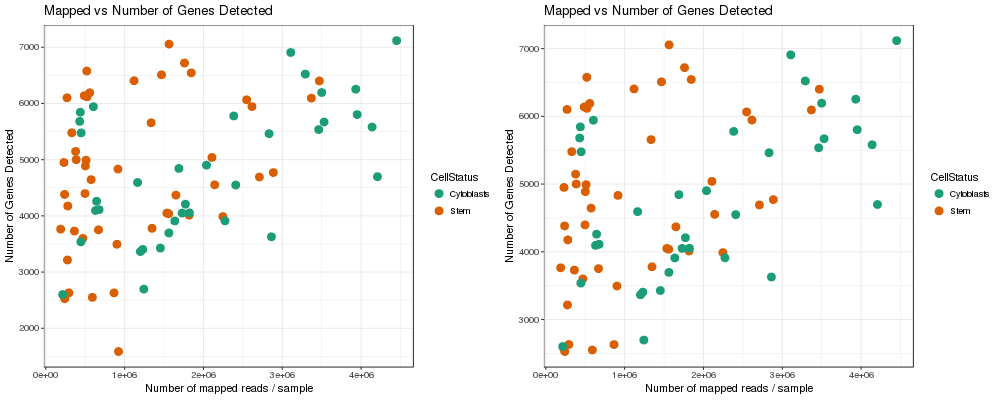

In [32]:
%%R -w 1000 -h 400
df<-data.frame(X=MappingSummary$Uniquely_mapped_reads_number,Y=MappingSummary$No_Genes_Detected, 
               CellStatus=as.factor(MappingSummary$CellType))
p1 <- ggplot(df, aes_string(x="X",y ="Y",color="CellStatus")) + 
     ggtitle("Mapped vs Number of Genes Detected") +
     geom_point(size=3.5) +
     labs(x = "Number of mapped reads / sample", y = "Number of Genes Detected") +
     scale_color_brewer(palette = "Dark2") +
     theme_bw()
     #geom_text(data=df,aes(label=names(mRNAno)),
     #          alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")

df2<-data.frame(X=MappingSummaryFilt$Uniquely_mapped_reads_number,Y=MappingSummaryFilt$No_Genes_Detected, 
               CellStatus=as.factor(MappingSummaryFilt$CellType))
p2 <- ggplot(df2, aes_string(x="X",y ="Y",color="CellStatus")) + 
     ggtitle("Mapped vs Number of Genes Detected") +
     geom_point(size=3.5) +
     labs(x = "Number of mapped reads / sample", y = "Number of Genes Detected") +
     scale_color_brewer(palette = "Dark2") +
     theme_bw()
     #geom_text(data=df,aes(label=names(mRNAno)),
     #          alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")


multiplot(p1, p2,cols=2)

In [33]:
%%R
cellToRemove <- MappingSummary[(MappingSummary$Uniquely_mapped_reads_number>500000 & MappingSummary$Visual_annotation > 1) | (MappingSummary$No_Genes_Detected >3000 & MappingSummary$Visual_annotation > 1),"CellName"]
cdFilteredSave <- cdFiltered
cdFiltered <- cdFiltered[, !(colnames(cdFiltered) %in% cellToRemove)]
print(paste("Before Filtering (genes): ", dim(cdAnnot)[1]))
print(paste("Before Filtering (Cells): ", dim(cdAnnot)[2]))
print(paste("After Filtering (genes): ", dim(cdFiltered)[1]))
print(paste("After Filtering (cells): ", dim(cdFiltered)[2]))

[1] "Before Filtering (genes):  17559"
[1] "Before Filtering (Cells):  84"
[1] "After Filtering (genes):  8613"
[1] "After Filtering (cells):  83"


So, after filtering it keeps 83 cells out of 84 cells.

In [34]:
%%R
FilteredDataInfo <- data.frame(Cell=colnames(cdFiltered), CellType=MappingSummaryFilt$CellType)
rownames(FilteredDataInfo ) <- colnames(cdFiltered)
pd <- new("AnnotatedDataFrame", data = FilteredDataInfo)
rownames(pd) <- pd$Cell
cdScesetFiltered <- newSCESet(countData = cdFiltered, phenoData = pd)
cdScesetFiltered <- calculateQCMetrics(cdScesetFiltered)

The name of the cells that remains after filtering are listed below

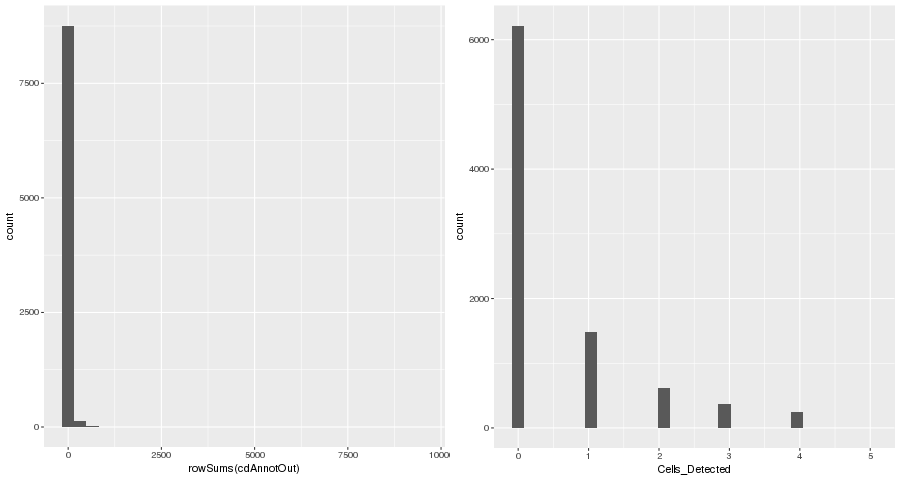

In [36]:
%%R -w 900
cdAnnotOut <- cdAnnot
cdAnnotOut <- cdAnnotOut[!(rownames(cdAnnotOut) %in% rownames(cdFiltered)),]
cdAnnotBinaryOut <- cdAnnotOut
cdAnnotBinaryOut[cdAnnotBinaryOut > 0] <- 1
Cells_Detected <- rowSums(cdAnnotBinaryOut)
p1 <- qplot(rowSums(cdAnnotOut), geom="histogram")
p2 <- qplot(Cells_Detected, geom="histogram")
multiplot(p1,p2, cols=2)

In [37]:
%%R
dim(cdAnnotOut)

[1] 8946   84


In [38]:
%%R
cdAnnotOut[rowSums(cdAnnotOut) > 5000,]

        A01 A02 A03 A04 A05 A06 A07 A08 A09 A10 A11 A12 B01 B02 B03 B04 B05 B06
Cyp4e3    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
CG18095   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
CG15406   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
        B07 B08 B09 B10 B11 B12 C01 C02 C03 C04 C05 C06 C07 C08 C09 C10 C11 C12
Cyp4e3    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
CG18095   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
CG15406   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
        D01 D02 D03 D04 D05 D06 D07 D08 D09 D10 D11 D12 E01 E02 E03 E04 E05 E06
Cyp4e3    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
CG18095   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
CG15406   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
        E07 E08 E09 E10 E11 E12 F01 F02 

In [39]:
%%R
print(paste0('Number of Genes having 0 count: ',sum(rowSums(cdAnnotOut) == 0)))
print(paste0('Number of Genes having 1 count: ',sum(rowSums(cdAnnotOut) == 1)))
print(paste0('Number of Genes having 2 counts: ',sum(rowSums(cdAnnotOut) == 2)))
print(paste0('Number of Genes having 3 counts: ',sum(rowSums(cdAnnotOut) == 3)))
print(paste0('Number of Genes having 4 counts: ',sum(rowSums(cdAnnotOut) == 4)))
print(paste0('Number of Genes having 5 counts: ',sum(rowSums(cdAnnotOut) == 5)))
print(paste0('Number of Genes having more than 5 counts: ',sum(rowSums(cdAnnotOut) > 5)))
#print('Genes having more than 5 counts')
#print(head(cdAnnotOut[rowSums(cdAnnotOut) > 5,]))
print('No. of cells observing more than 5 counts')
print(head(rowSums(cdAnnotBinaryOut[rowSums(cdAnnotOut) > 5,])))
print(paste0('Observed in 1 cells ',sum(rowSums(cdAnnotBinaryOut[rowSums(cdAnnotOut) > 5,]) == 1)))
print(paste0('Observed in 2 cells ', sum(rowSums(cdAnnotBinaryOut[rowSums(cdAnnotOut) > 5,]) == 2)))
print(paste0('Observed in 3 cells ', sum(rowSums(cdAnnotBinaryOut[rowSums(cdAnnotOut) > 5,]) == 3)))
print(paste0('Observed in more than 3 cells ', sum(rowSums(cdAnnotBinaryOut[rowSums(cdAnnotOut) > 5,]) >3)))
#head(rowSums(cdAnnotOut))

[1] "Number of Genes having 0 count: 6218"
[1] "Number of Genes having 1 count: 519"
[1] "Number of Genes having 2 counts: 185"
[1] "Number of Genes having 3 counts: 127"
[1] "Number of Genes having 4 counts: 87"
[1] "Number of Genes having 5 counts: 80"
[1] "Number of Genes having more than 5 counts: 1730"
[1] "No. of cells observing more than 5 counts"
 Abd-B    Ace   acj6 Act87E    Adh     ap 
     4      4      3      1      3      3 
[1] "Observed in 1 cells 704"
[1] "Observed in 2 cells 467"
[1] "Observed in 3 cells 319"
[1] "Observed in more than 3 cells 240"


In [41]:
%%R
select <- cdAnnotOut[rowSums(cdAnnotOut) > 5,]
#selectT <-cdAnnotBinaryOut[rowSums(cdAnnotBinaryOut[rownames(select),])>3,]
selectT <- cdAnnotBinaryOut[rownames(select),]
#selectT[rowSums(selectT)>3,]

In [42]:
%%R
print(rowSums(cdAnnotOut['Hsp70Bbb',]))
#print(rowSums(cdAnnotBinaryOut[892,]))

Hsp70Bbb 
       7 


## Coefficient of Variation after filtering

In [43]:
%%R
cellCVFiltered <- CV(colMeans(cdFiltered),apply(cdFiltered, 2, sd))
mRNACVFiltered <- CV(rowMeans(cdFiltered),apply(cdFiltered, 1, sd))

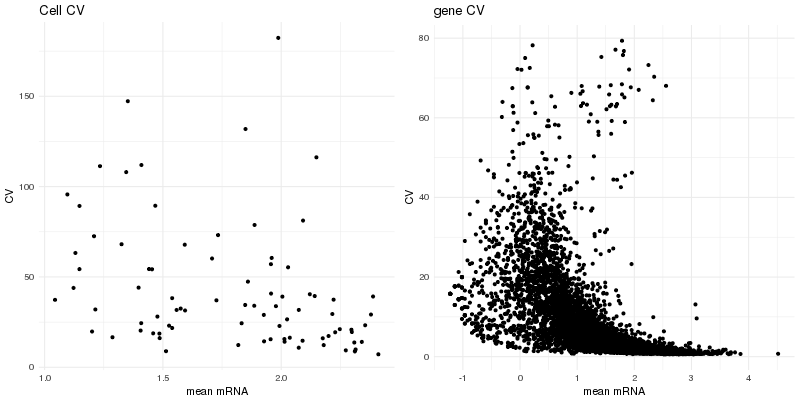

In [44]:
%%R -w 800 -h 400
df <- data.frame(X=log10(colMeans(cdFiltered)),Y=cellCVFiltered)
cellP <- ggplot(df, aes_string(x="X",y ="Y")) + 
      ggtitle("Cell CV") +
      geom_point(size=1.25) +
      labs(x = "mean mRNA", y = "CV") +
      theme_bw()+
      theme(legend.position = "none",
            legend.background = element_rect(fill = "white"),
            strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())

df <- data.frame(X=log10(rowMeans(cdFiltered)),Y=mRNACVFiltered)
mRNAP <- ggplot(df, aes_string(x="X",y ="Y")) + 
      ggtitle("gene CV") +
      geom_point(size=1.25) +
      labs(x = "mean mRNA", y = "CV") +
      theme_bw()+
      theme(legend.position = "none",
            legend.background = element_rect(fill = "white"),
            strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())

multiplot(cellP, mRNAP, cols=2)

In [45]:
%%R
write.csv(exprs(cdScesetFiltered), 'log2(cpm+1)_normalized_read_counts.csv')

In [46]:
%%R
cdScesetFiltered <- calculateQCMetrics(cdScesetFiltered)
plotQC(cdScesetFiltered, type = "highest-expression")


Error in `$<-.data.frame`(`*tmp*`, "Feature", value = integer(0)) : 
  replacement has 0 rows, data has 4150


/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

Error in `$<-.data.frame`(`*tmp*`, "Feature", value = integer(0)) : 
  replacement has 0 rows, data has 4150




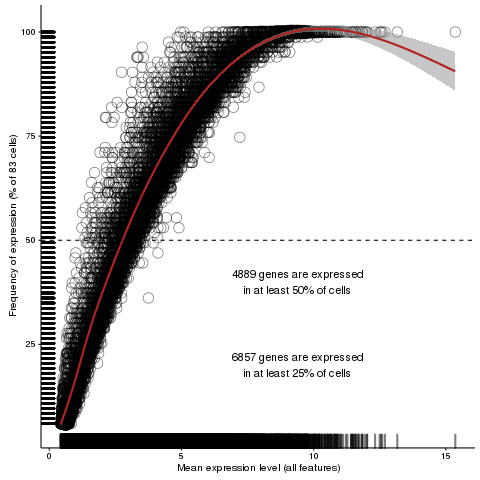

In [47]:
%%R
plotQC(cdScesetFiltered, type = "exprs-freq-vs-mean")

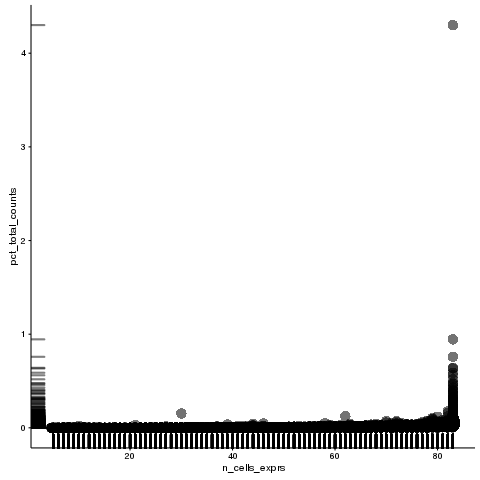

In [48]:
%%R
plotFeatureData(cdScesetFiltered, aes(x = n_cells_exprs, y = pct_total_counts))

In [49]:
%%R
featureData <- fData(cdScesetFiltered)
featureData <- featureData[order(featureData$pct_total_counts, decreasing=TRUE),]
head(featureData[,c('n_cells_exprs', 'pct_total_counts')],20)

              n_cells_exprs pct_total_counts
mt:lrRNA                 83        4.3003250
CG1746                   83        0.9448040
Cp36                     83        0.7581529
CR34335                  83        0.6411599
Cyp1                     83        0.6339340
Ef1alpha48D              83        0.5879584
Hsp83                    83        0.5612195
tsr                      83        0.5181993
dhd                      83        0.4780444
smt3                     83        0.4704570
Tsp42Ee                  83        0.4568279
mt:CoI                   83        0.4301127
14-3-3epsilon            83        0.4100250
CG9821                   83        0.3977078
His3.3B                  83        0.3936157
RpS3A                    83        0.3702380
mt:Cyt-b                 83        0.3700059
Cp38                     83        0.3585538
pAbp                     83        0.3315560
mt:CoII                  83        0.3234082


In [50]:
%%R
tail(featureData)

               mean_exprs exprs_rank n_cells_exprs total_feature_exprs
CG7304          0.4523629         15             5            37.54612
GstZ2           0.4429064          8             5            36.76123
CR40354         0.4463011          9             5            37.04299
CG34297         0.4427247          7             5            36.74615
7SLRNA:CR42652  0.4494644         12             5            37.30555
CR45162         0.4369678          2             5            36.26833
               pct_total_exprs pct_dropout total_feature_counts
CG7304             0.001453083     93.9759                    5
GstZ2              0.001422707     93.9759                    5
CR40354            0.001433611     93.9759                    5
CG34297            0.001422123     93.9759                    5
7SLRNA:CR42652     0.001443772     93.9759                    5
CR45162            0.001403631     93.9759                    5
               log10_total_feature_counts pct_total_cou

Above list shows the number of genes that are expressed in all the cells. Among those __mt:lrRNA__ is expressed in all the cells.

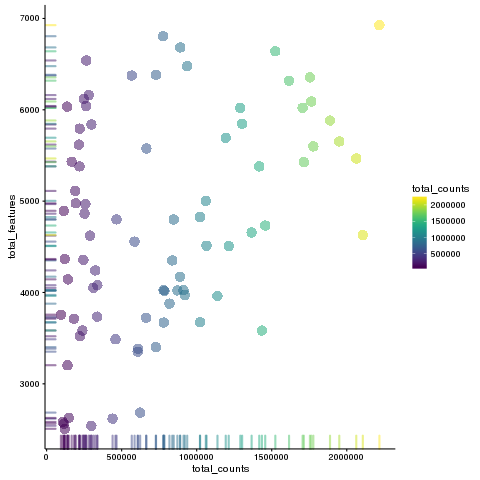

In [51]:
%%R
plotPhenoData(cdScesetFiltered, aes(x = total_counts, y = total_features,
                                  colour = total_counts))

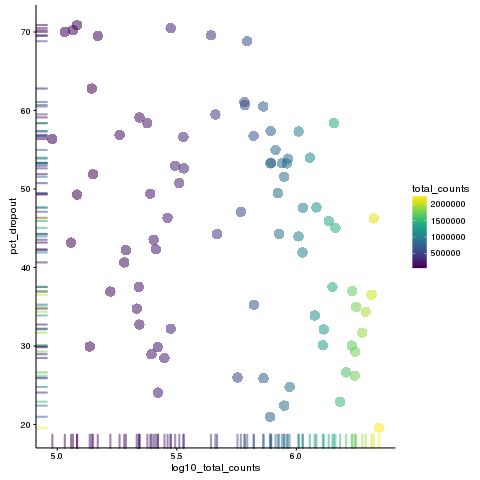

In [52]:
%%R
plotPhenoData(cdScesetFiltered, aes(x = log10_total_counts, y = pct_dropout,
                                  colour = total_counts))

* * *

## Starting analysis
From this point we start with the analysis we are looking for. 

#### PCA with 500 top mostly variable genes

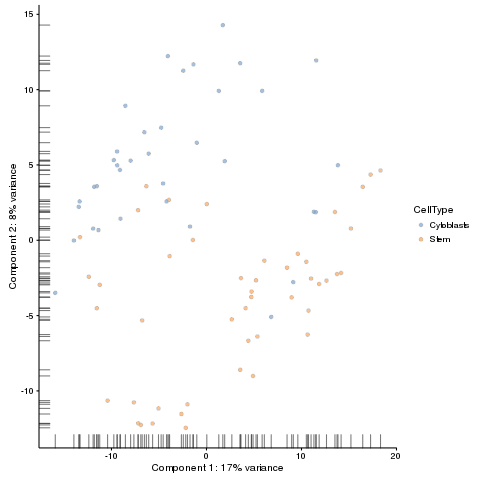

In [53]:
%%R
plotPCA(cdScesetFiltered, ncomponents = 2, colour_by = "CellType")

__There is no obvious clustering that shows up in the PCA using 500 mostly variable genes. I will try with tSNE to see whether something comes up__

### PCA with top 500 most variable genes. The plot below plots 4 principle components with the dataset

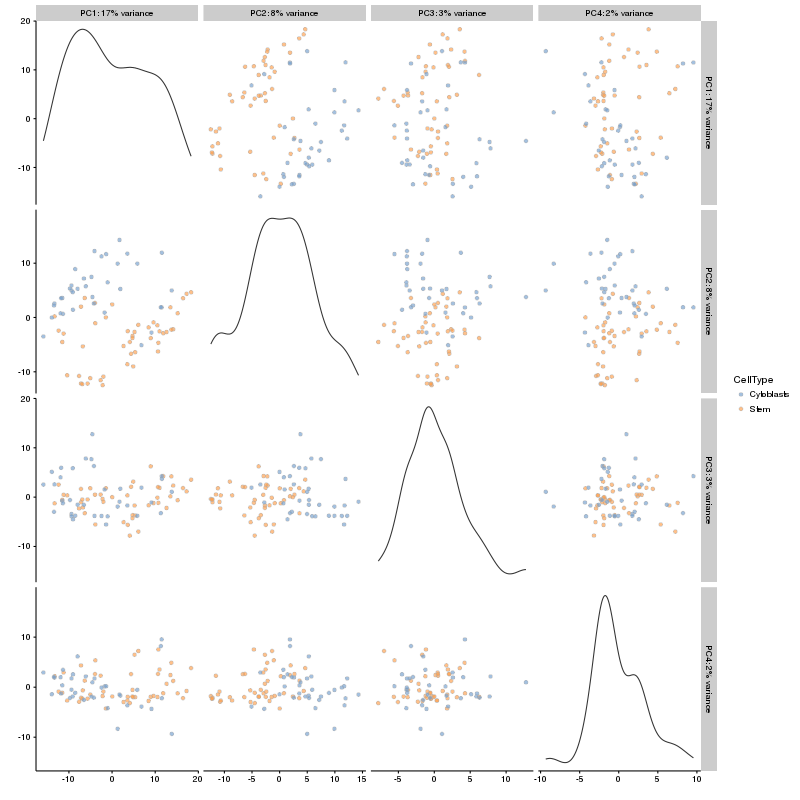

In [54]:
%%R -w 800 -h 800
plotPCA(cdScesetFiltered, ncomponents = 4, ntop=500,colour_by = "CellType")

### PCA with all the genes (not only the 500 top most variable genes)

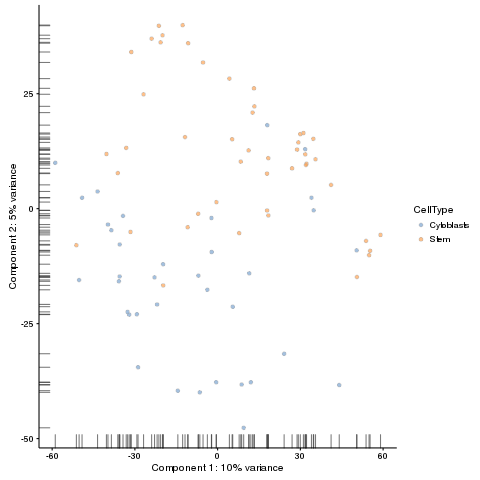

In [55]:
%%R
plotPCA(cdScesetFiltered, ncomponents = 2, ntop=dim(cdFiltered)[1], colour_by = "CellType")

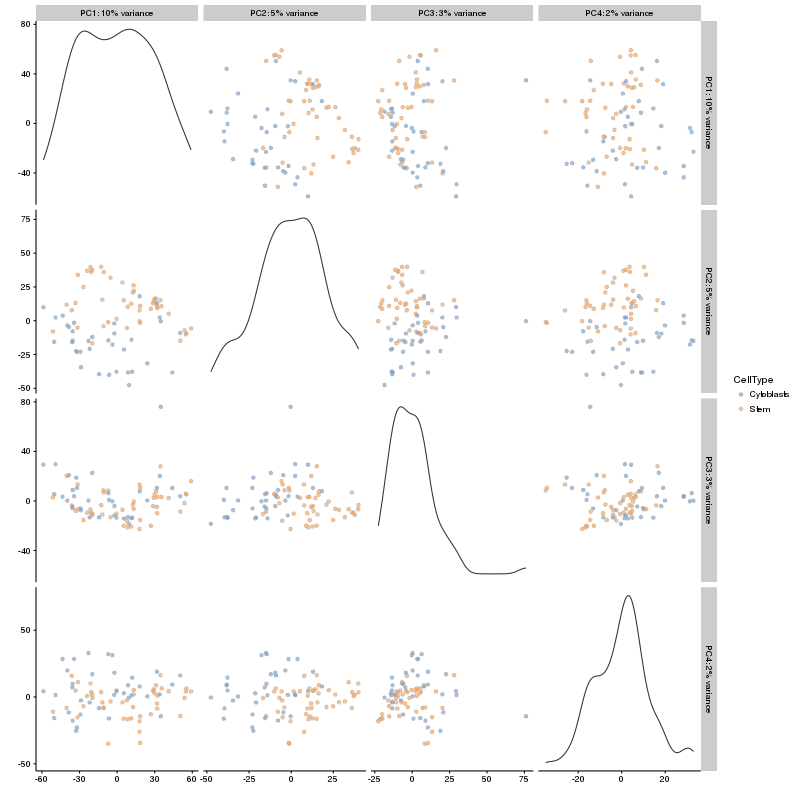

In [56]:
%%R -w 800 -h 800
plotPCA(cdScesetFiltered, ncomponents = 4, ntop=dim(cdFiltered)[1], colour_by = "CellType")

#### t-SNE
We are now applying t-SNE to see whether the visualization improves.

First we calculate the PCAs taking 500 most variable genes.

But we first plot the 4 PCs again wiht the most 500 variable genes

In [57]:
%%R
#set.seed(1)
#FinalPCAData <- t(exprs(cdScesetFiltered))
#pcaPRComp <- prcomp(FinalPCAData)
rowVarsSorted <- exprs(cdScesetFiltered)[order(rowVars(exprs(cdScesetFiltered)), decreasing=TRUE),]
FinalPCAData <- t(rowVarsSorted[1:500,])
pcaPRComp <- prcomp(FinalPCAData)

In [58]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

#pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1))
#rownames(pca_var_out) <- rownames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

 plot: [1,2] [=====---------------------------------] 12% est: 1s 



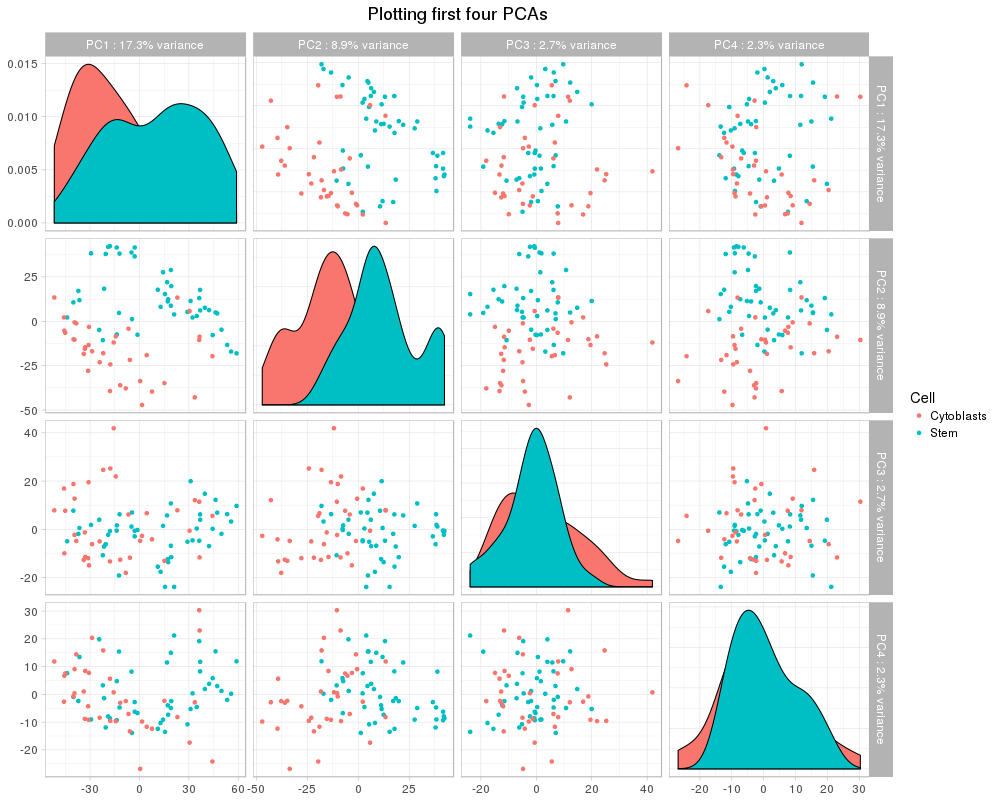

In [60]:
%%R -w 1000 -h 800
# Set the number of columns you like to display
nColToDisplay = 4
df <- as.data.frame(pcaPRComp$x)
df$Cell=as.factor(MappingSummaryFilt$CellType)
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+     
    theme(plot.title = element_text(hjust = 0.5))
    
print(p)

This is the same figure I generate earlier with 500 highly variable genes, but a bit more clear now. Also information in this plot would be used for t-SNE calculation.

First we find out how much variance is explained by majority of the PCAs.

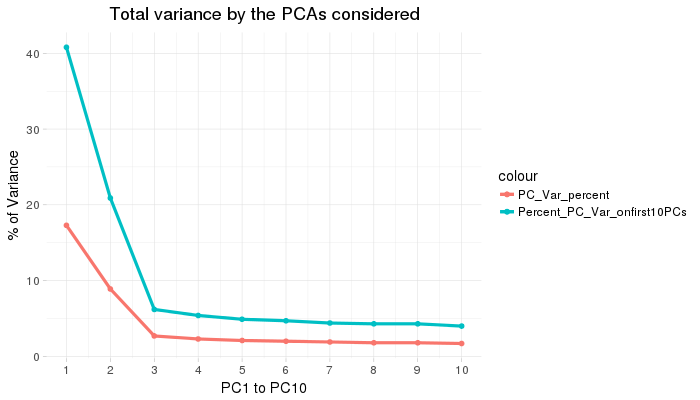

In [61]:
%%R -w 700 -h 400
p <- ggplot(pca_var_out[1:10,])
p <- p + geom_line(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size=1.5)+
         geom_point(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size = 2)+
         geom_line(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size=1.5)+
         geom_point(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size = 2)+
         ggtitle("Total variance by the PCAs considered")+
         xlab(paste("PC1 to PC10"))+
         ylab(paste("% of Variance"))+     
         theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())+
         scale_x_continuous(breaks=c(1:10))
print(p)

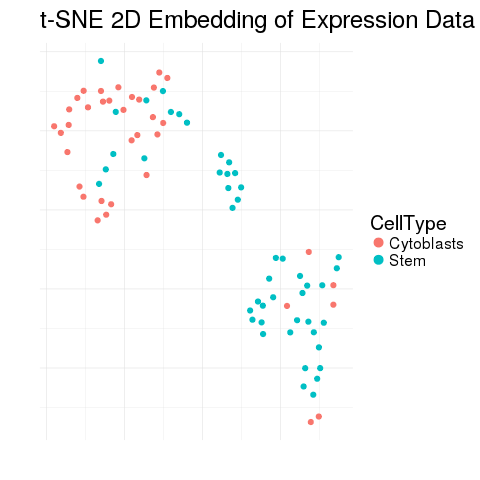

In [63]:
%%R
tsne_out <- Rtsne(as.matrix(pcaPRComp$x[,1:8]),check_duplicates = FALSE, pca = TRUE, 
              perplexity=dim(FinalPCAData)[1]/8, theta=0.5, dims=2)

CellType <- as.factor(MappingSummaryFilt$CellType)
p <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=CellType)) +
     geom_point(size=2.25) +
     guides(colour = guide_legend(override.aes = list(size=4))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D Embedding of Expression Data") +
     theme_light(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
print(p)

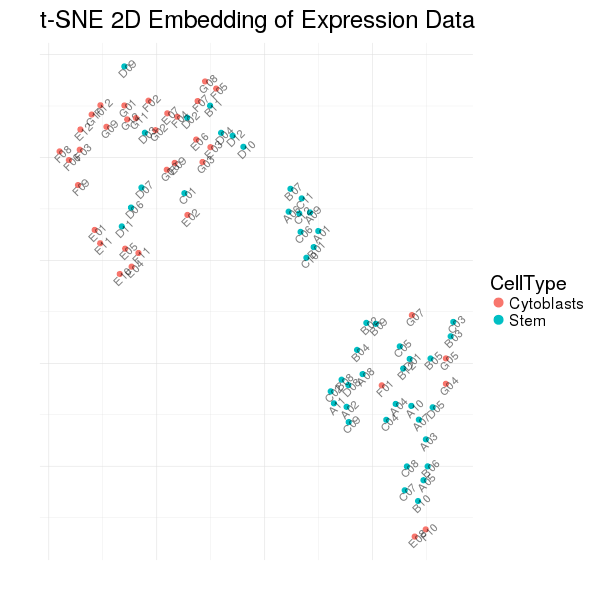

In [64]:
%%R -w 600 -h 600
#df<- as.data.frame(CellType = as.factor(MappingSummaryFilt$CellType)) 
p <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=CellType)) +
     geom_point(size=2.25) +
     guides(colour = guide_legend(override.aes = list(size=4))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D Embedding of Expression Data") +
     theme_light(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())

p <- p + geom_text(aes(label=rownames(MappingSummaryFilt)),
               alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p)

__Looking at the tSNE plot, I would take that there are three clusters. Although, this was not obvious from the PCA plot but we can see it in the tSNE plot. It would be interesting to see the differential expression of the genes between the groups. I will keep it for the next stage!!!__

Also, in this analysis I used 8 significant PCs to calculate t-SNE values. But just came across a paper where they have permuted the dataset to see how much variability does the PCs contribute without being affected by noise. I will now implement this method to improve t-SNE visualization.

### Heatmap

I will now draw the heatmap using 500 most highly variable genes. I am not showing it here as it takes lots of memory to show it in a jupyter notebook.

In [275]:
%%R
# Taking CPM normalized value for clustering from cdScesetFiltered
cdFilteredForCluster <- exprs(cdScesetFiltered)
cdFilteredForCluster <- cdFilteredForCluster[order(rowVars(cdFilteredForCluster), decreasing = TRUE)[1:500],]
colAnnot = data.frame(type = c(rep('Rep1',Rep1No), rep('Rep2',Rep2No)))
ha = HeatmapAnnotation(df = colAnnot)

###############################
# I turned this Heatmap option off as it took lots of memory to run from jupyter notebook
pdf("CPM_Normalized_Low_Threshold_HirerClust.pdf", height=1000, width=1700)
Heatmap(cdFilteredForCluster, show_row_dend=FALSE, show_row_names = FALSE, column_names_gp = gpar(fontsize = 9), top_annotation = ha)
dev.off()

png 
  2 


### M3Drop to find Differentially Expressed Genes
Using MM3Drop to find the differentially expressed genes. MM3Drop use Michaelis-Menten curve to find differentially expressed (DE) genes. I found this technique to give the best result with respect to FDR. However, they do not say which group of genes they are differentially expressed, rather shows the genes that are differentially expressed on the whole set of single-cells. The purple colour genes are the significant ones.

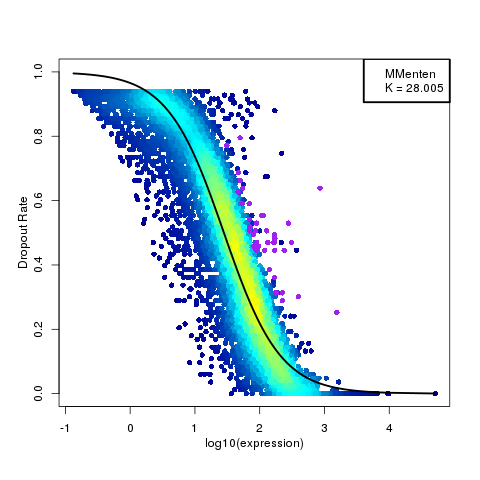

In [65]:
%%R
M3DropSignificantGenes <- M3DropDifferentialExpression(2^exprs(cdScesetFiltered), mt_threshold=0.05)

In [66]:
%%R
M3DropSignificantGenesSorted <- M3DropSignificantGenes[order(M3DropSignificantGenes$q.value, decreasing=FALSE),]
M3DropSignificantGenesSorted

             Gene      p.value      q.value
cona         cona 5.888678e-32 5.071919e-28
fs(1)K10 fs(1)K10 4.495556e-27 3.872022e-23
CG2233     CG2233 5.750884e-26 4.953237e-22
w               w 3.596878e-22 3.097991e-18
Timp         Timp 4.442134e-19 3.826010e-15
CG32088   CG32088 3.812843e-17 3.284002e-13
CG30383   CG30383 1.682605e-15 1.449228e-11
CG32243   CG32243 1.091667e-14 9.402532e-11
CG7800     CG7800 1.708920e-14 1.471893e-10
CG34323   CG34323 3.332929e-14 2.870652e-10
CG14932   CG14932 2.299736e-13 1.980762e-09
CG32280   CG32280 7.738501e-13 6.665171e-09
CG4250     CG4250 4.435156e-11 3.820000e-07
CG8316     CG8316 1.681794e-10 1.448529e-06
bam           bam 3.810169e-10 3.281698e-06
CG31262   CG31262 1.644113e-08 1.416075e-04
Tsp42Ed   Tsp42Ed 3.556234e-08 3.062984e-04
Ant2         Ant2 3.590192e-08 3.092232e-04
eIF4E-3   eIF4E-3 3.821122e-08 3.291132e-04
CG14883   CG14883 4.757497e-08 4.097633e-04
RpS19b     RpS19b 7.709181e-08 6.639918e-04
CG8097     CG8097 1.073254e-07 9

In [67]:
%%R
write.csv(M3DropSignificantGenesSorted, 'M3DropSignificantGenes_R_2_cell_4updated.csv')

In [68]:
%%R
save.image("Scott_Workspace_R2_C4_updated.RData")

## Using Monocole-2 to do Bifurcation analysis

In [69]:
%%R
cellPhenoData <- data.frame(cells= colnames(cdFiltered), celltype=MappingSummaryFilt$CellType)
count_matrix <- cdFiltered
geneNames <- rownames(cdFiltered)

pd <- new("AnnotatedDataFrame", data = cellPhenoData)
rownames(pd) <- cellPhenoData$cells

fd <- new("AnnotatedDataFrame", data = as.data.frame(geneNames))
rownames(fd) <- fd$geneNames

cdMonocle <- newCellDataSet(as.matrix(count_matrix),
                              phenoData = pd,
                              featureData = fd,
                              expressionFamily=negbinomial())

cdMonocle <- estimateSizeFactors(cdMonocle)
cdMonocle <- estimateDispersions(cdMonocle)

cdMonocle  <- detectGenes(cdMonocle , min_expr = 0.1)
print(head(fData(cdMonocle)))
expressed_genes <- row.names(subset(fData(cdMonocle), num_cells_expressed >= 20))

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

Removing 64 outliers




        geneNames num_cells_expressed
a               a                  63
Abl           Abl                  44
abo           abo                  45
Acph-1     Acph-1                  67
mAChR-A   mAChR-A                   7
Act5C       Act5C                  83


Above we select genes for which normalized expression value is above 0.1.

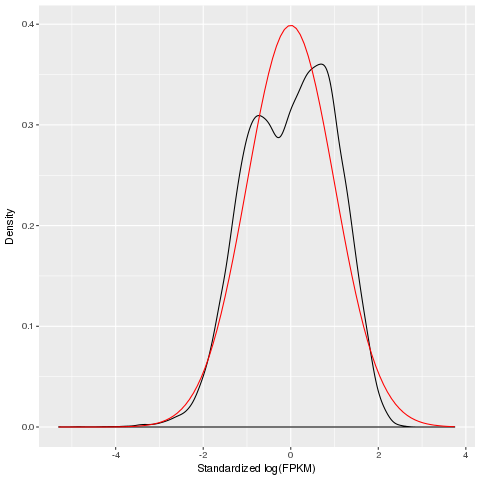

In [70]:
%%R
L <- log(exprs(cdMonocle))
# Standardize each gene, so that they are all on the same scale,
# Then melt the data with plyr so we can plot it easily"
melted_dens_df <- melt(Matrix::t(scale(Matrix::t(L))))
# Plot the distribution of the standardized gene expression values.
qplot(value, geom="density", data=melted_dens_df) +  stat_function(fun = dnorm, size=0.5, color='red') +xlab("Standardized log(FPKM)") +ylab("Density")

Standarizing the genes

In [71]:
%%R
table(pData(cdMonocle)$celltype)


Cytoblasts       Stem 
        36         47 


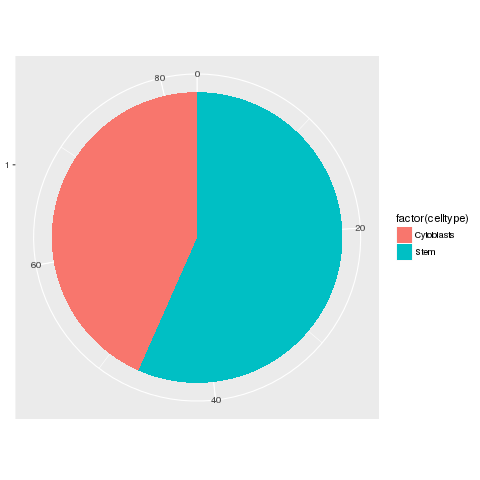

In [72]:
%%R
pie <- ggplot(pData(cdMonocle), aes(x = factor(1), fill = factor(celltype))) +
geom_bar(width = 1)
pie + coord_polar(theta = "y") +
theme(axis.title.x=element_blank(), axis.title.y=element_blank())

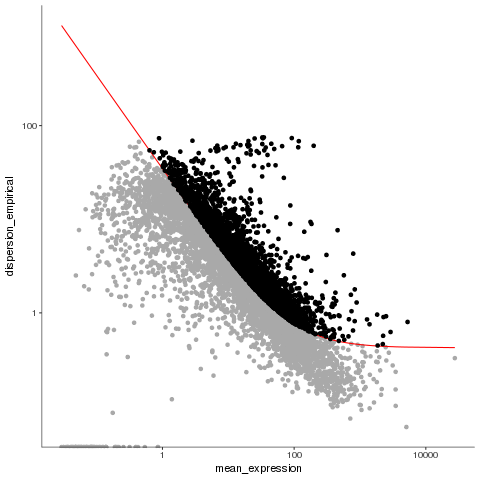

In [73]:
%%R
disp_table <- dispersionTable(cdMonocle)
unsup_clustering_genes <- subset(disp_table, mean_expression >= 0.1 & dispersion_empirical >= 1 * dispersion_fit)
cdMonocle <- setOrderingFilter(cdMonocle, unsup_clustering_genes$gene_id)
plot_ordering_genes(cdMonocle)

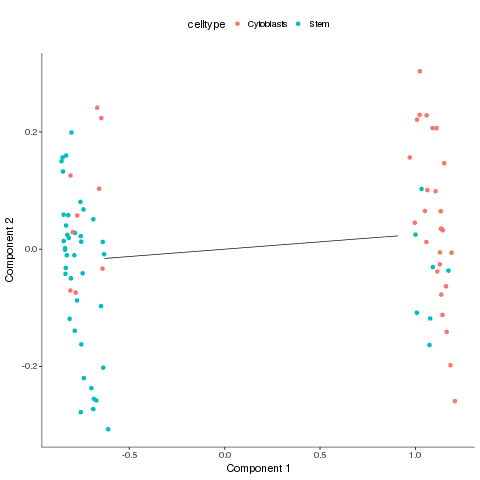

In [74]:
%%R
cdMonocle <- clusterCells(cdMonocle, num_clusters=2)
plot_cell_trajectory(cdMonocle, 1, 2, color="celltype")

Just shows how the cluseters differentiate between the two cell types with the genes selected.

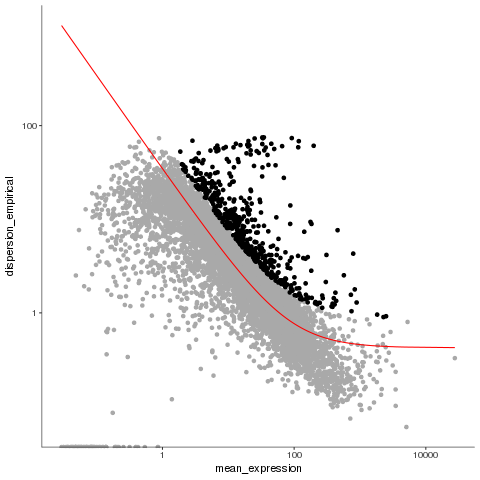

In [75]:
%%R
disp_table <- dispersionTable(cdMonocle)
ordering_genes <- subset(disp_table,
mean_expression >= 0.5 &
dispersion_empirical >= 2 * dispersion_fit)$gene_id
cdMonocle <- setOrderingFilter(cdMonocle, ordering_genes)
plot_ordering_genes(cdMonocle)

__Following is the most intersting figure in this analysis as it shows the actual differentiation pathway.__

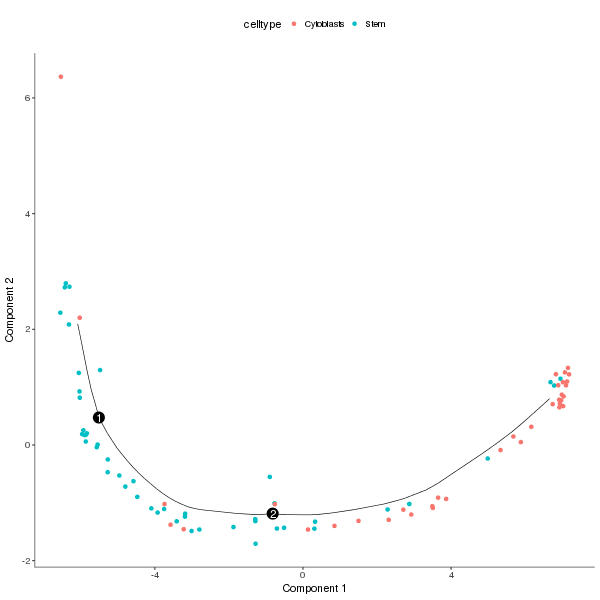

In [76]:
%%R -w 600 -h 600
cdMonocle <- reduceDimension(cdMonocle, max_components=2)
cdMonocle <- orderCells(cdMonocle, reverse=FALSE)
plot_cell_trajectory(cdMonocle, color_by="celltype")

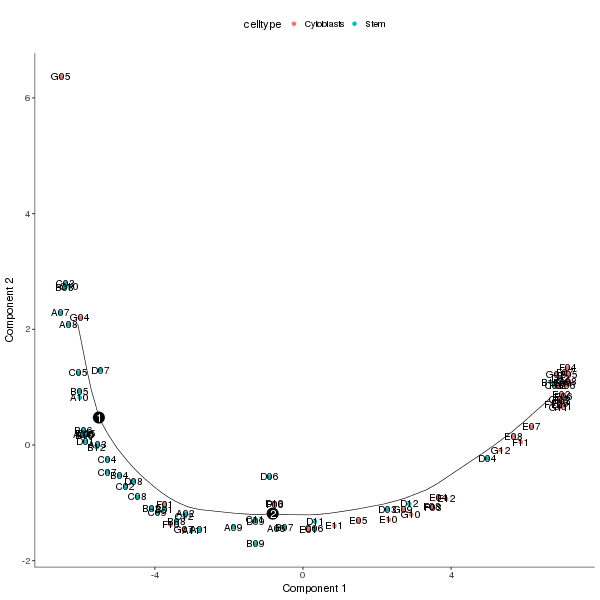

In [77]:
%%R -w 600 -h 600
plot_cell_trajectory(cdMonocle, color_by="celltype", show_cell_names=TRUE, show_tree=TRUE, cell_name_size=3.5)

It looks like monocle-2 has picked up only __1__ differentiation pathway. However, this need to be validated by looking at the genes

## PAGODA analysis
I will now do the pathway cell clustering based on the variability of the genes within a GO ontology. I will do this analysis in the command prompt and will give the user the url to browse the results.

Please click on the following link to access PAGODA analysis

[PAGODA Link Read 2 Cell 4 Filter](http://130.88.91.152:2186/custom/Scott_Cell_R2_C4/index.html)

## Mapping Drosophelia gene to Mouse gene

In [5]:
%%R
load("Scott_Workspace_R2_C4_updated.RData")

In [8]:
%%R
library(biomaRt)
library(GO.db)

In [9]:
%%R
# Initialize the connection to the Ensembl BioMart Service
# Available datasets can be listed with 
# listDatasets(useMart("ensembl"))
# Use mmusculus_gene_ensembl for mouse
# For mouse symbols we can use "mgi_symbol"
ensemblMouse <- useMart("ensembl", dataset = "mmusculus_gene_ensembl")
ensemblDros <- useMart("ensembl", dataset = "dmelanogaster_gene_ensembl")

In [10]:
%%R
rownames(cdFiltered)[which(rownames(cdFiltered) == 'beta\'COP')]<-"beta_COP"
rownames(cdFiltered)[which(rownames(cdFiltered) == 'PP2A-B\'')] <- 'PP2A-B'

In [11]:
%%R
GenesLinked <- getLDS(attributes = c("ensembl_gene_id", "flybasename_gene"), filters = "flybasename_gene", values = rownames(cdFiltered), mart = ensemblDros, attributesL = c("ensembl_gene_id", "mgi_symbol") , martL = ensemblMouse)

In [13]:
%%R
write.csv(GenesLinked,'DrosopheliaAndMouseGeneLinked.csv')

In [20]:
%%R
GenesLinked[GenesLinked$FlyBaseName.gene == 'mAChR-A',]

         Gene.ID FlyBaseName.gene          Gene.ID.1 MGI.symbol
2013 FBgn0000037          mAChR-A ENSMUSG00000045613      Chrm2
6619 FBgn0000037          mAChR-A ENSMUSG00000040495      Chrm4


In [44]:
%%R
cdFilteredGenesLinked <- as.data.frame(cdFiltered)
cdFilteredGenesLinked$MouseGeneName <- GenesLinked[match(rownames(cdFilteredGenesLinked),GenesLinked$FlyBaseName.gene), 'MGI.symbol']
cdFilteredGenesLinked$MouseGeneID <- GenesLinked[match(rownames(cdFilteredGenesLinked),GenesLinked$FlyBaseName.gene), 'Gene.ID.1']
cdFilteredGenesLinked <- cdFilteredGenesLinked[!is.na(cdFilteredGenesLinked$MouseGeneName),]
rownames(cdFilteredGenesLinked) <- make.names(cdFilteredGenesLinked$MouseGeneID, unique=TRUE)
cdFilteredGenesLinked <- cdFilteredGenesLinked[ , !(colnames(cdFilteredGenesLinked) %in% c("MouseGeneName"))]
cdFilteredGenesLinked <- cdFilteredGenesLinked[ , !(colnames(cdFilteredGenesLinked) %in% c("MouseGeneID"))]

In [45]:
%%R
head(cdFilteredGenesLinked)

                   A01 A02 A03 A04 A05 A06 A07 A08 A09 A10 A11 B01  B02 B03 B04
ENSMUSG00000026842  24  92   7   2   0   1   0   0   3   0   0  17   60   0   0
ENSMUSG00000030610   0   0   0 127   0  61   0   0  26   0 125  34    0   0   0
ENSMUSG00000002103 676 246 108 271   0  45  99  60  74 595 356 646 1632  79  87
ENSMUSG00000045613   0   0   0   0   0   0   0   0   0   0   0   0    0   0   0
ENSMUSG00000020899  81  34  60   0   0  22   8  25  41   0  19  78    1   0   0
ENSMUSG00000022962 537 327 180   0 108  25 319  82 150 235  16 555  653 131 105
                   B05 B06 B07 B08 B09 B10 B11 B12 C01 C02 C03 C04 C05 C06 C07
ENSMUSG00000026842   6   0   3   1   0   0   9   0  24  29   7   0   1   0   0
ENSMUSG00000030610  40   0  59   0   0   0  42   0 128 291   0   0   0  24   0
ENSMUSG00000002103  98  20  25  32  54   0 154 663 133 161  55  63  74  36  56
ENSMUSG00000045613   0   0   0   0   0   0   6   0  16   0   0   0   0   0   0
ENSMUSG00000020899   0   0   8   7  52   0  5

In [46]:
%%R
FilteredDataInfoReas <- data.frame(Cell=colnames(cdFilteredGenesLinked), Status=gsub('([A-z]+)_.*', '\\1', colnames(cdFilteredGenesLinked)))
rownames(FilteredDataInfoReas) <- colnames(cdFilteredGenesLinked)
pd <- new("AnnotatedDataFrame", data = FilteredDataInfoReas)
rownames(pd) <- pd$Cell
featureDataInfo <- data.frame(geneName = rownames(cdFilteredGenesLinked))
rownames(featureDataInfo) <- rownames(featureDataInfo)
fd <- new("AnnotatedDataFrame", data = featureDataInfo)
rownames(fd) <- rownames(cdFilteredGenesLinked)
cdSCFilteredGenesLinked <- newSCESet(countData = cdFilteredGenesLinked, phenoData = pd, featureData = fd)
mg.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))

In [47]:
%%R
save.image("Scott_Workspace_R2_C4_updated.RData")

In [48]:
%%R
assigned <- cyclone(cdSCFilteredGenesLinked, pairs=mg.pairs)
head(assigned$scores)

     G1     S   G2M
1 0.673 0.272 0.234
2 0.455 0.049 0.284
3 0.520 0.005 0.489
4 0.333 0.205 0.509
5 0.538 0.310 0.542
6 0.449 0.336 0.471


In [49]:
%%R
phase <- rep("S", ncol(cdSCFilteredGenesLinked))
phase[assigned$scores$G1 > 0.5] <- "G1"
phase[assigned$scores$G2M > 0.5] <- "G2M"
phase[assigned$scores$G1 > 0.5 & assigned$scores$G2M > 0.5] <- "unknown"
table(phase)

phase
     G1     G2M       S unknown 
     25      33      12      13 


In [52]:
%%R
labels.qseq <- rep("Cell", length(pData(cdSCFilteredGenesLinked)$Cell))
df.scores<-data.frame(x=assigned$scores[,1], 
                      y=assigned$scores[,3], 
                      z=labels.qseq )

In [67]:
%%R
plot.scores.self <- function(df, Cell, Status,legend.title, plot.title){  
  
  df$Status <- as.factor(Status) 
  p<-ggplot(data=df, aes(x=x,y=y,color=Status))
  p+geom_point(size=2)+
    xlab("G1 score")+
    ylab("G2M score")+
    ylim(0,1)+
    xlim(0,1)+
    ggtitle(plot.title)+
    theme(axis.title.x = element_text(size=10, vjust=-2),
          axis.text.x  = element_text( size=10),
          axis.title.y = element_text( size=10,vjust=2),
          axis.text.y  = element_text( size=10)) +
    theme(plot.margin=unit(c(1,1,1.5,1.2),"cm"))+
    theme(legend.text=element_text(size=10),#size of legend
          legend.title=element_text(size=10), 
          plot.title = element_text(size=20, face="bold"))+
    scale_color_discrete(name=legend.title)+
    geom_segment(aes(x = 1/2, y = 0, xend=1/2, yend=1/2),colour="black") + 
    geom_segment(aes(x = 0, y = 1/2, xend=1/2, yend=1/2),colour="black") +
    geom_segment(aes(x = 1/2, y = 1/2, xend=1, yend=1),colour="black") +
    annotate("text", x=0.05, y=0.05, label="S", size=8)+
    annotate("text", x=0.95, y=0.25, label="G1", size=8)+
    annotate("text", x=0.25, y=0.95, label="G2M", size=8)+
    geom_text(data=df,aes(label=Cell),alpha=0.5,size=5, vjust=1,hjust=0.5,angle=45, color="black")  
  
}

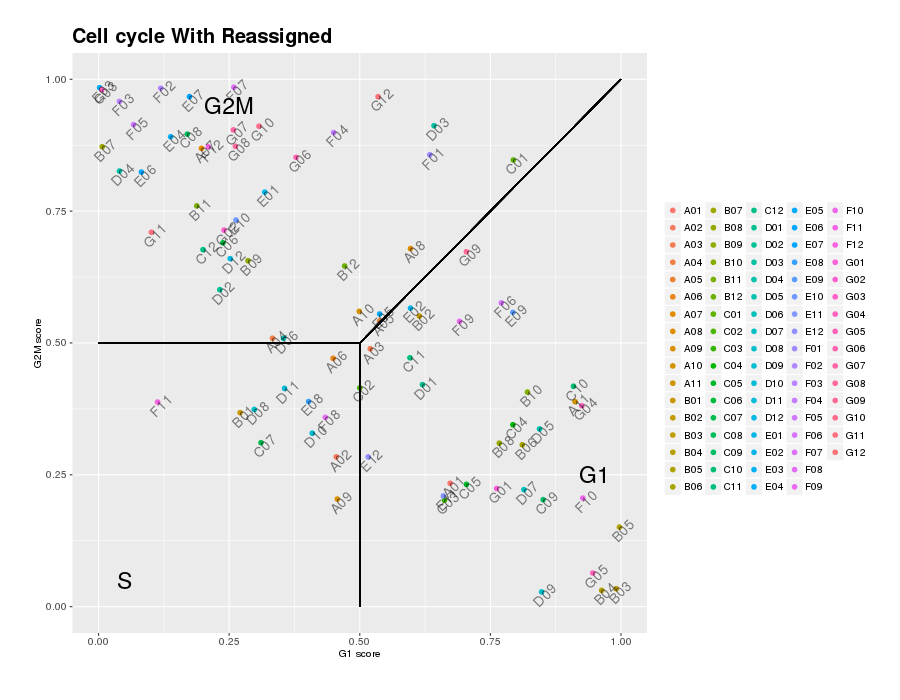

In [69]:
%%R -w 900 -h 700
plot.scores.self(df.scores,gsub('([A-z]+)', '\\1',(pData(cdSCFilteredGenesLinked)$Cell)), pData(cdSCFilteredGenesLinked)$Status, legend.title="",plot.title="Cell cycle With Reassigned")